In [3]:
import numpy as np
import graphinglib as gl
from astropy.io import fits
from astropy.constants import c as light_speed
from matplotlib.colors import ListedColormap

from src.hdu.map import Map
from src.hdu.grouped_maps import GroupedMaps
from src.coordinates.celestial_coords import RA, DEC
from src.coordinates.fits_coords import FitsCoords
from src.tools.loki import get_loki_line_pdfs_figure, get_loki_fit_figure


gm = GroupedMaps.load_from_loki(
    "data/loki/output_NGC4696_G235H_F170LP_full_model/NGC4696_G235H_F170LP_full_model_parameter_maps.fits"
)
SNR_cut = 3

# Finding the AGN pixel coordinate
# --------------------------------
header = gm["LINES.H210_Q7.TOTAL_FLUX"].header
world_coords = [RA.from_sexagesimal("12:48:49.2609").degrees, DEC.from_sexagesimal("-41:18:39.417").degrees]
coords = header.world_to_pixel(world_coords)[0][::-1]  # x, y
print(coords)

# Rotate this coord
# -----------------
# theta = np.radians(-47)
# rotated_coords = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ coords
# print(rotated_coords)

# GL useful elements
arrows = [
    gl.Arrow((7.8+20, 2-23), (12.8+20, 7-23), "black"),
    gl.Arrow((8.2+20, 2-23), (3.2+20, 7-23), "black"),
    gl.Text(13+20, 7-23, "N", color="black", font_size=15, h_align="center", v_align="bottom"),
    gl.Text(3+20, 7-23, "E", color="black", font_size=15, h_align="center", v_align="bottom"),
]
AGN_pos = gl.Point(40.3, 0, marker_style="x", color="red", marker_size=50)

[29.18404284 26.68426572]


### Fig 1

In [ ]:
data = fits.open(
    "data/output_NGC4696_G235H_F170LP_full_model/NGC4696_G235H_F170LP_full_model_parameter_maps.fits"
)[67].data  # H_2(1-0)
hm = gl.Heatmap(data, origin_position="lower", show_color_bar=False, color_map_range=(-18, -16))
zoomed_hm = gl.Heatmap(data[24:33,24:33], origin_position="lower", show_color_bar=False, color_map_range=(-18, -16))
zoomed_hm_2 = zoomed_hm.copy()
zoomed_hm_2.image = zoomed_hm.image[2:7,2:7]
zoomed_hm_2.color_map = "plasma"

fig = gl.SmartFigure(
    2,
    2,
    remove_x_ticks=True,
    remove_y_ticks=True,
    size=(11, 6),
    width_ratios=[5, 2],
    reference_labels=False,
    width_padding=0,
    height_padding=0,
).set_visual_params(use_latex=True)
fig[:, 0] = [
    hm,
    gl.Text(1, 54, "NGC 4696 ($z=0.0104$)", h_align="left"),
    gl.Text(1, 52, "Central dominant galaxy in the Centaurus Cluster", h_align="left"),
    gl.Text(1, 3, r"H$\alpha$ HST ...", h_align="left"),
    gl.Text(1, 1, r"Chandra X-ray (blue) ...", h_align="left"),
    gl.Text(28, 35, r"[Chandra X-ray + H$\alpha$ HST image"+"\nof the whole cluster]", font_size=20),
    gl.Line((45, 1), (55, 1), capped_line=True, cap_width=0.5, width=1),
    gl.Text(50, 2, "x kpc"),
    gl.Rectangle(23.5, 23.5, 9, 9, fill=False),
    gl.Polygon([[9+23.5, 23.5], [9+23.5, 9+23.5], [60, 60], [60, 28.7]], fill=False),
]
fig[0, 1] = [
    zoomed_hm,
    gl.Text(4, 3, "[Identify with\narrows the AGN\nand filaments]", font_size=15),
    gl.Text(6.5, 7.3, "x kpc"),
    gl.Line((5, 7), (8, 7), capped_line=True, cap_width=0.5, width=1),
    gl.Rectangle(1.5, 1.5, 5, 5, fill=False),
    gl.Polygon([[-0.5, -0.5], [1.5, 1.5], [6.5, 1.5], [9.5, -1.5]], fill=False),
]
fig[1, 1] = [
    zoomed_hm_2,
    gl.Rectangle(0.5, 0.5, 3, 3, fill=False),
    gl.Text(2, 4, "[MUSE velocity field]", font_size=15),
    gl.Text(2, 3.1, "[NIRSpec's FOV]", font_size=15),
    gl.Line((2, 0), (4, 0), capped_line=True, cap_width=0.5, width=1),
    gl.Text(3, 0.2, "x kpc"),
]
fig.show().save("figures/article/fig_1.pdf", dpi=600)

### Fig 2

In [ ]:
# H210_Q7 [327, 336, 89] and stars [429, 5, 6]
lines = [f"LINES.H210_Q7.{p}" for p in ["TOTAL_FLUX", "VPEAK", "1.FWHM"]]
lines += [f"CONTINUUM.STELLAR_{p}" for p in ["POPULATIONS.MASS", "KINEMATICS.VEL", "KINEMATICS.VDISP"]]
hms = []
texts = [gl.Text(59, 19.5, "H$_2$ 1-0 $Q(7)$", h_align="right", v_align="top")]*3

for i, line in enumerate(lines):
    map_ = gm[line]
    # map_.data[*np.round(coords).astype(int)] = np.nan
    if i < 3:
        # Mask with an SNR cut
        map_ = map_.mask(gm[f"{line[:14]}TOTAL_SNR"].data > SNR_cut)

    match i % 3:
        case 0: cmap = "plasma"
        case 1: cmap = "coolwarm"
        case 2: cmap = "viridis"
    match i:
        case 0: cbar_label = r"$\log_{10}(F_\mathrm{gas}/$ erg s$^{-1}$ cm$^{-2})$"
        case 1: cbar_label = "velocity $v_\mathrm{gas}$ (km s$^{-1}$)"
        case 2:
            map_ /= 2 * np.sqrt(2 * np.log(2))  # FWHM to sigma
            cbar_label = r"velocity dispersion $\sigma_\mathrm{gas}$ (km s$^{-1}$)"
        case 3: cbar_label = r"$\log_{10}(M_\star/M_{\odot})$"
        case 4: cbar_label = "velocity $v_\star$ (km s$^{-1}$)"
        case 5: cbar_label = r"velocity dispersion $\sigma_\star$ (km s$^{-1}$)"

    hm = map_.rotate_field()
    hm.color_map = cmap
    if i < 3: hm.set_color_bar_params(position="top", label=cbar_label)
    else: hm.set_color_bar_params(position="bottom", label=cbar_label)
    hms.append(hm)

arrows = [
    gl.Arrow((7.8+20, 2-23), (12.8+20, 7-23), "black"),
    gl.Arrow((8.2+20, 2-23), (3.2+20, 7-23), "black"),
    gl.Text(13+20, 7-23, "N", color="black", font_size=15, h_align="center", v_align="bottom"),
    gl.Text(3+20, 7-23, "E", color="black", font_size=15, h_align="center", v_align="bottom"),
]
AGN_pos = gl.Point(40.3, 0, marker_style="x", color="red", marker_size=50)
AGN_text = gl.Text(37.3, 2, r"$\textbf{AGN}$", color="red", font_size=14, h_align="center", v_align="center")
radio_contours = gl.Contour.from_function(
    lambda x, y: np.exp(-0.5*(((x-40.3)/6)**2 + ((y-0)/3)**2)), (20, 60), (-23, 20), 2, ListedColormap(["red"]),
    show_color_bar=False, filled=False, alpha=0.5,
)
fig = gl.SmartFigure(
    2,
    3,
    # aspect_ratio=1,
    size=(9.12, 8),
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=hms,
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    x_lim=(20, 60),
    y_lim=(-23, 20),
)
fig.add_elements(*[[*arrows, AGN_pos, AGN_text, radio_contours]]*6)#.set_reference_labels_params(color="black", font_size=15)
fig.add_elements(*texts)
for i, cmap_range in enumerate([(-18.27, -17.53), (-460, 250), (30, 340), (6.5, 7.24), (-50, 50), (230, 325)]):
    hms[i].color_map_range = cmap_range
fig.set_visual_params(use_latex=True).show().save("figures/article/fig_2_v4.pdf", dpi=600)

In [ ]:
left_fig = gl.SmartFigure(
    2,
    1,
    aspect_ratio=1,
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[flux_hm, flux_hm],
    reference_label_loc="inside",
).add_elements(*[arrows]*2)
middle_right_fig = gl.SmartFigure(
    2,
    2,
    aspect_ratio=1,
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[vel_hm_0, sig_hm_0, vel_hm, sig_hm],
    reference_label_loc="inside",
    height_ratios=[5, 6.5]
).add_elements(*[arrows]*4)
global_fig = gl.SmartFigure(
    1,
    2,
    size=(10, 6),
    elements=[left_fig, middle_right_fig],
    width_ratios=[1, 2],
).set_visual_params(use_latex=True).show()#.save("figures/article/fig_2.pdf", dpi=600)

### Fig 3

In [ ]:
# First page of Fig.3 will contain the S1 -> S6 maps
lines = [f"H210_S{i}" for i in range(1, 7)]
# get_loki_line_pdfs_figure(lines).save("figures/tests/all_S.pdf", dpi=600)
texts = []
for i in range(1, 7):
    texts.extend([gl.Text(48, 16, rf"H$_2$ 1-0 $S({i})$", font_size=10)]*3)
    # texts.extend([rf"H$_2$ $1-0$ $S({i}$)", None, None])

hms = []
for i, line in enumerate(lines):
    for type_ in ["TOTAL_FLUX", "VPEAK", "1.FWHM"]:
        map_ = gm[f"LINES.{line}.{type_}"]
        map_ = map_.mask(gm[f"LINES.{line}.TOTAL_SNR"].data > SNR_cut)
        hms.append(map_.rotate_field())

    hms[-3].color_map = "plasma"
    hms[-2].color_map = "coolwarm"
    hms[-1].color_map = "viridis"
    hms[-1].image /= 2 * np.sqrt(2 * np.log(2))  # FWHM to sigma
    hms[-3].color_map_range = -18.4, -17.2
    hms[-2].color_map_range = -450, 450
    hms[-1].color_map_range = 50, 340

for hm in hms[3:]:
    hm.show_color_bar = False

hms[0].set_color_bar_params(position="top", label=r"$\log(F/$ erg s$^{-1}$ cm$^{-2})$")
hms[1].set_color_bar_params(position="top", label="$v$ (km s$^{-1}$)")
hms[2].set_color_bar_params(position="top", label=r"$\sigma$ (km s$^{-1}$)")

fig = gl.SmartFigure(
    6,
    3,
    # aspect_ratio=1,
    size=(4.85, 11),
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=hms,
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    x_lim=(20, 60),
    y_lim=(-23, 20),
    height_ratios=[1.33, 1, 1, 1, 1, 1],
    reference_labels=False,
).set_visual_params(use_latex=True)
fig.add_elements(*[arrows]*3)
fig.add_elements(*[AGN_pos]*18)
fig.add_elements(*texts)
# fig.show()
fig.save("figures/article/fig_3_1_v2.pdf", dpi=600)

In [ ]:
# Second page of Fig.3 will contain the O2, Br beta, O3, Pa alpha, Q7 maps
# lines = ["H210_O2", "H210_O3", "H210_Q7", "HI_Br_beta", "HI_Pa_alpha"]
# get_loki_line_pdfs_figure(lines).save("figures/tests/all_fig_3_2.pdf", dpi=600)
lines = ["H210_O2", "H210_O3", "H210_Q7", "HI_BR_BETA", "HI_PA_ALPHA"]
texts = []
for label in ["H$_2$ 1-0 $O(2)$", "H$_2$ 1-0 $O(3)$", "H$_2$ 1-0 $Q(7)$", r"Br$\beta$", r"Pa$\alpha$"]:
    texts.extend([gl.Text(58, 16, label, font_size=10, h_align="right")]*3)

hms = []
for i, line in enumerate(lines):
    for type_ in ["TOTAL_FLUX", "VPEAK", "1.FWHM"]:
        map_ = gm[f"LINES.{line}.{type_}"]
        map_ = map_.mask(gm[f"LINES.{line}.TOTAL_SNR"].data > SNR_cut)
        hms.append(map_.rotate_field())

    hms[-3].color_map = "plasma"
    hms[-2].color_map = "coolwarm"
    hms[-1].color_map = "viridis"
    hms[-1].image = hms[-1].image / (2 * np.sqrt(2 * np.log(2)))  # FWHM to sigma
    hms[-3].color_map_range = -18.8, -17.2
    hms[-2].color_map_range = -450, 450
    hms[-1].color_map_range = 50, 340

for hm in hms[3:]:
    hm.show_color_bar = False

hms[0].set_color_bar_params(position="top", label=r"$\log(F/$ erg s$^{-1}$ cm$^{-2})$")
hms[1].set_color_bar_params(position="top", label="$v$ (km s$^{-1}$)")
hms[2].set_color_bar_params(position="top", label=r"$\sigma$ (km s$^{-1}$)")

fig = gl.SmartFigure(
    5,
    3,
    # aspect_ratio=1,
    size=(5.8, 11),
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=hms,
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    x_lim=(20, 60),
    y_lim=(-23, 20),
    height_ratios=[1.285, 1, 1, 1, 1],
    reference_labels=False,
).set_visual_params(use_latex=True)
fig.add_elements(*[arrows]*3)
fig.add_elements(*[AGN_pos]*15)
fig.add_elements(*texts)
# fig.show()
fig.save("figures/article/fig_3_2_v2.pdf", dpi=600)

### Tests

In [ ]:
file = "output_NGC4696_G235H_F170LP_full_model_stars_full"
# file = "output_NGC4696_G235H_F170LP_full_model_stars_Pa+H2"

lines = [f"H210_{i}" for i in ["O2", "O3", "O4", "Q6", "Q7", "Q8", "Q9", "S0", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8"]]
lines = ["HI_Pa_alpha", "H210_S3"]

fig = get_loki_line_pdfs_figure(lines, file)
fig.save("figures/workshop/test_1.pdf", dpi=600)

In [ ]:
hm = gm["LINES.H210_Q7.TOTAL_SNR"].data.plot
hm.color_map_range = 0, 10
gl.SmartFigure(
    aspect_ratio=1,
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[hm],
).show()


In [ ]:
fig = gl.SmartFigure(3, 9)
fig[0, :3] = []
fig[0, 3:6] = []
fig[0, 6:] = []
fig[1, 1:4] = []
fig[1, 5:8] = []
fig[2, 3:6] = []
fig.show()

In [ ]:
fig = gl.SmartFigure(2, 4)
fig[0, :2] = []
fig[0, 2:] = []
fig[1, 1:3] = []
fig.show()

Set DATE-AVG to '2025-06-05T03:01:04.882' from MJD-AVG.
Set DATE-END to '2025-06-05T05:04:12.748' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.562604 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731901716.684 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.562604 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731901716.684 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.562604 from OBSGEO-[XYZ].
Set OBSGEO-H to 1731901716.684 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


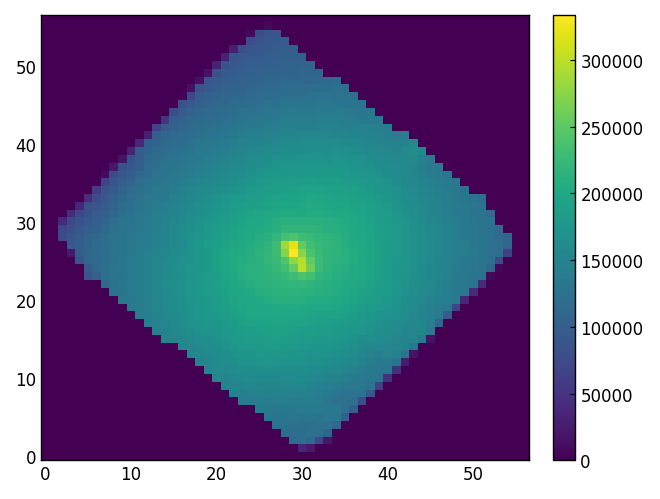

In [2]:
from src.hdu.cube import Cube
import graphinglib as gl

cube = Cube.load("data/f170lp_g235h-f170lp_s3d_choiclip1_2_wicked.fits", 1)
df = cube.get_deep_frame()
gl.SmartFigure(elements=[df.data.plot]).show()

In [ ]:
%matplotlib tk
get_loki_fit_figure(
    "data/loki/output_NGC4696_G235H_F170LP_full_model_stars_full/NGC4696_G235H_F170LP_full_model_stars_full_full_model.fits",
    (32, 27),
).show()

In [2]:
from src.tools.loki import get_loki_fit_figure
from src.coordinates.fits_coords import FitsCoords

%matplotlib tk
get_loki_fit_figure(
    "data/loki/output_NGC4696_G235H_F170LP_full_model_stars_full/NGC4696_G235H_F170LP_full_model_stars_full_full_model.fits",
    FitsCoords(30, 26),
).show()